In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
sns.set_palette("Set2")

In [30]:
from dotenv import load_dotenv
from ephys_queries import db_setup_core, select_spike_times, select_discrete_data
from scipy.ndimage import gaussian_filter1d
from scipy.stats import zscore

In [31]:
from spiketimes.df.binning import binned_spiketrain_bins_provided
from spiketimes.df.statistics import diffmeans_test_by
from spiketimes.df.baseline import zscore_standardise_by
from spiketimes.utils import p_adjust

In [32]:
data_dir = Path(".").absolute().parent / "data"
fig_dir = Path(".").absolute().parent / "figs"

In [33]:
group_names = ["acute_citalopram", 
            "acute_saline", 
            "shock", 
            "sham", 
            "acute_cit", 
            "acute_sal"]
dfb = (
    pd.read_csv(data_dir / "baseline.csv")
    .loc[lambda x: x["group_name"].isin(group_names)]
)

dfe = pd.read_csv(data_dir / "psth_responses.csv")

In [34]:
block_name = "base_shock"
t_before = 10 * 60
t_after = 10 * 60
fs = 30000
load_dotenv()
engine, metadata = db_setup_core()

df_spikes = (
    select_spike_times(
            engine, 
            metadata,
            t_before=t_before,
            t_after=t_after,
            group_names=group_names,
            block_name=block_name,
            align_to_block=True
            )
    .assign(spiketimes=lambda x: x["spike_time_samples"].divide(fs))
)

In [35]:
df_spikes.head(3)

,neuron_id,spike_time_samples,group_name,spiketimes
0,1031,-17999918,acute_cit,-599.997267
1,1031,-17996357,acute_cit,-599.878567
2,1031,-17993978,acute_cit,-599.799267


In [36]:
def response_dm(row, p_col="p_dm", diff_mean_col="diff_of_means"):
    if row[p_col] >= 0.05:
        return "Non Responder"
    elif row[diff_mean_col] < 0:
        return "Inhibited"
    else:
        return "Stimulated"
    
def percent_baseline(df):
    mean_baseline = df.loc[lambda x: x.time < 0].spike_counts.mean()
    return df.assign(pct_baseline=lambda x: x.spike_counts.divide(mean_baseline))

In [37]:
binsize = 30
bins = np.arange(-600, 1320, binsize)

df_ts = (
    binned_spiketrain_bins_provided(
        df_spikes, 
        bins, 
        spiketimes_col="spiketimes",                     
        spiketrain_col="neuron_id"
    )
    .rename(columns={"counts": "spike_counts", "bin": "time"})
    .merge(dfb[["neuron_id", "cluster", "group_name"]])
    .assign(condition=lambda x: 
            x["time"].apply(lambda y: "Baseline" if y < 0 else "Shock" if y < 600 else "Post"),
           firing_rate=lambda x: x["spike_counts"].divide(binsize),
        )
)

In [38]:
df_ts

,neuron_id,time,spike_counts,cluster,group_name,condition,firing_rate
0,1031,-600,347,slow_regular,acute_cit,Baseline,11.566667
1,1031,-570,370,slow_regular,acute_cit,Baseline,12.333333
2,1031,-540,368,slow_regular,acute_cit,Baseline,12.266667
3,1031,-510,374,slow_regular,acute_cit,Baseline,12.466667
4,1031,-480,369,slow_regular,acute_cit,Baseline,12.300000
...,...,...,...,...,...,...,...
16438,2003,1140,169,slow_regular,acute_sal,Post,5.633333
16439,2003,1170,187,slow_regular,acute_sal,Post,6.233333
16440,2003,1200,176,slow_regular,acute_sal,Post,5.866667
16441,2003,1230,179,slow_regular,acute_sal,Post,5.966667


In [11]:
df_res = (
    df_ts
    .loc[lambda x: x.condition.isin(["Baseline", "Shock"])]
    .assign(cond=lambda x: x.condition.map(
        {"Baseline":0, "Shock":1, }
    ))
    .pipe(lambda x: diffmeans_test_by(df=x, 
                                       n_boot=5000,
                                       spiketrain_col="neuron_id",
                                       spikecount_col="firing_rate",
                                       condition_col="cond")
         )
    .assign(p=lambda x: p_adjust(x.p))
    .rename(columns={"diff_of_means": "DOM_shock", "p": "p_shock"})
    .assign(response_shock = lambda x: x.apply(response_dm, 
                                               p_col="p_shock", 
                                               diff_mean_col="DOM_shock",
                                               axis=1)
           )
)

In [12]:
df_res = (
    df_ts
    .loc[lambda x: x.condition.isin(["Shock", "Post"])]
    .assign(cond=lambda x: x.condition.map(
        {"Shock":0, "Post":1, }
    ))
    .pipe(lambda x: diffmeans_test_by(df=x, 
                                       n_boot=5000,
                                       spiketrain_col="neuron_id",
                                       spikecount_col="firing_rate",
                                       condition_col="cond")
         )
    .assign(p=lambda x: p_adjust(x.p, "Bonferroni"))
    .rename(columns={"diff_of_means": "DOM_post", "p": "p_post"})
    .assign(response_post = lambda x: x.apply(response_dm, 
                                               p_col="p_post", 
                                               diff_mean_col="DOM_post",
                                               axis=1)
           )
    .merge(df_res)
)

In [13]:
(
    df_res
    .merge(dfe[["neuron_id", "response_baseshock", "cluster"]])
    .to_csv(data_dir / "baseshock_ramping.csv", index=False)
)

# Heats

## SR

In [14]:

df_heat = (
    df_ts
    .pipe(lambda x: zscore_standardise_by(df=x, 
                      baseline_start_stop=np.array([-600, 0]),
                      time_col="time",
                      data_col="firing_rate", 
                      spiketrain_col="neuron_id"))
    .assign(z_smooth= lambda x: x.groupby("neuron_id")["zscore"]
                    .transform(lambda x: gaussian_filter1d(x, sigma=1.1)))
    .pivot(columns="time", index="neuron_id", values="z_smooth")
    .reset_index()
    .merge(dfb[["neuron_id", "cluster"]])
    .merge(df_res[["neuron_id", "response_shock"]])
)

c1 = (
    df_heat
    .loc[lambda x: x.cluster == "slow_regular"]
    .loc[lambda x: x["response_shock"] == "Stimulated"]
    .drop(["neuron_id", "response_shock", "cluster"], axis=1)
    .sort_values(by=60, ascending=False)
    .dropna()
)

c2 = (
    df_heat
    .loc[lambda x: x.cluster == "slow_regular"]
    .loc[lambda x: x["response_shock"] == "Inhibited"]
    .drop(["neuron_id", "response_shock", "cluster"], axis=1)
    .sort_values(by=60, ascending=False)
    .dropna()
)

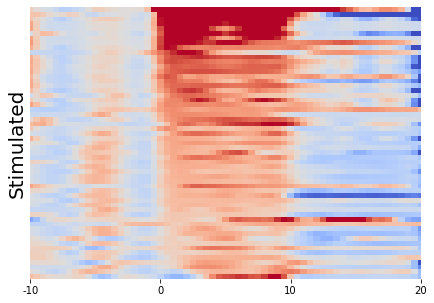

In [15]:
f, ax = plt.subplots(figsize=(7, 5))
ax.imshow(c1, cmap="coolwarm", vmin=-4.5, vmax=4.5, aspect="auto")


ax.set_ylabel("Stimulated", fontsize=20)
ax.set_yticklabels([])
ax.set_yticks([])

ax.set(frame_on=False)
ax.set_xlim(0, 60)
ax.set_xticks([0, 20, 40, 60])
ax.set_xticklabels([-10, 0, 10, 20])

plt.savefig(fig_dir / "SR_ramp_heat_activated.svg", transparent=True, dpi=300)

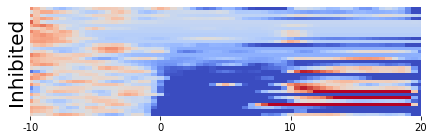

In [16]:
f, ax = plt.subplots(figsize=(7, 2))
ax.imshow(c2, cmap="coolwarm",vmin=-3, vmax=3, aspect="auto")


ax.set_ylabel("Inhibited", fontsize=20)
ax.set_yticklabels([])
ax.set_yticks([])

ax.set(frame_on=False)
ax.set_xlim(0, 60)
ax.set_xticks([0, 20, 40, 60])
ax.set_xticklabels([-10, 0, 10, 20])

plt.savefig(fig_dir / "SR_ramp_heat_inhibited.svg", transparent=True, dpi=300)

## FF

In [17]:
df_heat = (
    df_ts
    .pipe(lambda x: zscore_standardise_by(df=x, 
                      baseline_start_stop=np.array([-600, 0]),
                      time_col="time",
                      data_col="firing_rate", 
                      spiketrain_col="neuron_id"))
    .assign(z_smooth= lambda x: x.groupby("neuron_id")["zscore"]
                    .transform(lambda x: gaussian_filter1d(x, sigma=0.7)))
    .pivot(columns="time", index="neuron_id", values="z_smooth")
    .reset_index()
    .merge(dfb[["neuron_id", "cluster"]])
    .merge(df_res[["neuron_id", "response_shock"]])
)

c1 = (
    df_heat
    .loc[lambda x: x.cluster == "fast_firing"]
    .loc[lambda x: x["response_shock"] == "Stimulated"]
    .drop(["neuron_id", "response_shock", "cluster"], axis=1)
    .sort_values(by=60, ascending=False)
    .dropna()
)

c2 = (
    df_heat
    .loc[lambda x: x.cluster == "fast_firing"]
    .loc[lambda x: x["response_shock"] == "Inhibited"]
    .drop(["neuron_id", "response_shock", "cluster"], axis=1)
    .sort_values(by=60, ascending=False)
    .dropna()
)

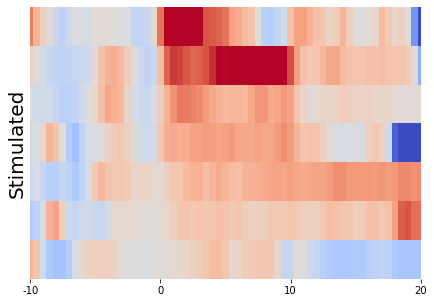

In [18]:
f, ax = plt.subplots(figsize=(7, 5))
ax.imshow(c1, cmap="coolwarm", vmin=-4.5, vmax=4.5, aspect="auto")


ax.set_ylabel("Stimulated", fontsize=20)
ax.set_yticklabels([])
ax.set_yticks([])

ax.set(frame_on=False)
ax.set_xlim(0, 60)
ax.set_xticks([0, 20, 40, 60])
ax.set_xticklabels([-10, 0, 10, 20])

plt.savefig(fig_dir / "FF_ramp_heat_activated.svg", transparent=True, dpi=300)

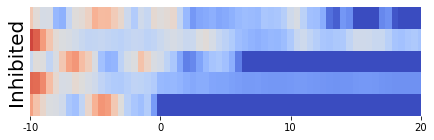

In [19]:
f, ax = plt.subplots(figsize=(7, 2))
ax.imshow(c2, cmap="coolwarm",vmin=-3, vmax=3, aspect="auto")


ax.set_ylabel("Inhibited", fontsize=20)
ax.set_yticklabels([])
ax.set_yticks([])

ax.set(frame_on=False)
ax.set_xlim(0, 60)
ax.set_xticks([0, 20, 40, 60])
ax.set_xticklabels([-10, 0, 10, 20])
plt.savefig(fig_dir / "FF_ramp_heat_inhibited.svg", transparent=True, dpi=300)

## SIR

In [20]:
df_heat = (
    df_ts
    .pipe(lambda x: zscore_standardise_by(df=x, 
                      baseline_start_stop=np.array([-600, 0]),
                      time_col="time",
                      data_col="firing_rate", 
                      spiketrain_col="neuron_id"))
    .assign(z_smooth= lambda x: x.groupby("neuron_id")["zscore"]
                    .transform(lambda x: gaussian_filter1d(x, sigma=0.9)))
    .pivot(columns="time", index="neuron_id", values="z_smooth")
    .reset_index()
    .merge(dfb[["neuron_id", "cluster"]])
    .merge(df_res[["neuron_id", "response_shock"]])
)

c1 = (
    df_heat
    .loc[lambda x: x.cluster == "slow_irregular"]
    .loc[lambda x: x["response_shock"] == "Stimulated"]
    .drop(["neuron_id", "response_shock", "cluster"], axis=1)
    .sort_values(by=60, ascending=False)
    .dropna()
)

c2 = (
    df_heat
    .loc[lambda x: x.cluster == "slow_irregular"]
    .loc[lambda x: x["response_shock"] == "Inhibited"]
    .drop(["neuron_id", "response_shock", "cluster"], axis=1)
    .sort_values(by=60, ascending=False)
    .dropna()
)

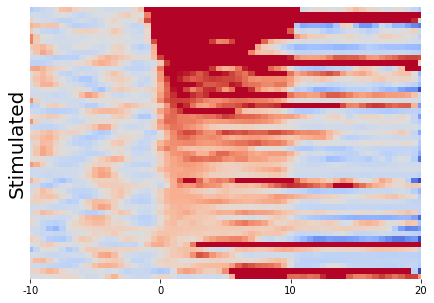

In [21]:
f, ax = plt.subplots(figsize=(7, 5))
ax.imshow(c1, cmap="coolwarm", vmin=-4.5, vmax=4.5, aspect="auto")


ax.set_ylabel("Stimulated", fontsize=20)
ax.set_yticklabels([])
ax.set_yticks([])

ax.set(frame_on=False)
ax.set_xlim(0, 60)
ax.set_xticks([0, 20, 40, 60])
ax.set_xticklabels([-10, 0, 10, 20])

plt.savefig(fig_dir / "SIR_ramp_heat_activiated.svg", transparent=True, dpi=300)

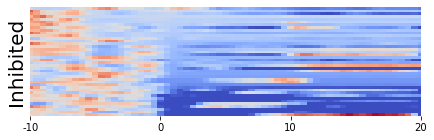

In [22]:
f, ax = plt.subplots(figsize=(7, 2))
ax.imshow(c2, cmap="coolwarm",vmin=-3, vmax=3, aspect="auto")


ax.set_ylabel("Inhibited", fontsize=20)
ax.set_yticklabels([])
ax.set_yticks([])

ax.set(frame_on=False)
ax.set_xlim(0, 60)
ax.set_xticks([0, 20, 40, 60])
ax.set_xticklabels([-10, 0, 10, 20])
plt.savefig(fig_dir / "SIR_ramp_heat_inhibited.svg", transparent=True, dpi=300)

## NSA

In [23]:
df_heat = (
    df_ts
    .pipe(lambda x: zscore_standardise_by(df=x, 
                      baseline_start_stop=np.array([-600, 0]),
                      time_col="time",
                      data_col="firing_rate", 
                      spiketrain_col="neuron_id"))
    .assign(z_smooth= lambda x: x.groupby("neuron_id")["zscore"]
                    .transform(lambda x: gaussian_filter1d(x, sigma=0.9)))
    .pivot(columns="time", index="neuron_id", values="z_smooth")
    .reset_index()
    .merge(dfb[["neuron_id", "cluster"]])
    .merge(df_res[["neuron_id", "response_shock"]])
)

c1 = (
    df_heat
    .loc[lambda x: x.cluster == "no_baseline"]
    .loc[lambda x: x["response_shock"] == "Stimulated"]
    .drop(["neuron_id", "response_shock", "cluster"], axis=1)
    .sort_values(by=60, ascending=False)
    .dropna()
)

c2 = (
    df_heat
    .loc[lambda x: x.cluster == "no_baseline"]
    .loc[lambda x: x["response_shock"] == "Inhibited"]
    .drop(["neuron_id", "response_shock", "cluster"], axis=1)
    .sort_values(by=60, ascending=False)
    .dropna()
)

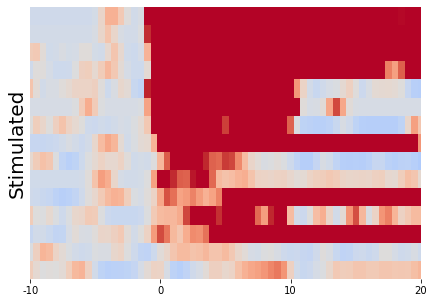

In [25]:
f, ax = plt.subplots(figsize=(7, 5))
ax.imshow(c1, cmap="coolwarm", vmin=-4.5, vmax=4.5, aspect="auto")


ax.set_ylabel("Stimulated", fontsize=20)
ax.set_yticklabels([])
ax.set_yticks([])

ax.set(frame_on=False)
ax.set_xlim(0, 60)
ax.set_xticks([0, 20, 40, 60])
ax.set_xticklabels([-10, 0, 10, 20])

plt.savefig(fig_dir / "NSA_ramp_heat_activiated.svg", transparent=True, dpi=300)

[Text(0, 0, '-10'), Text(0, 0, '0'), Text(0, 0, '10'), Text(0, 0, '20')]

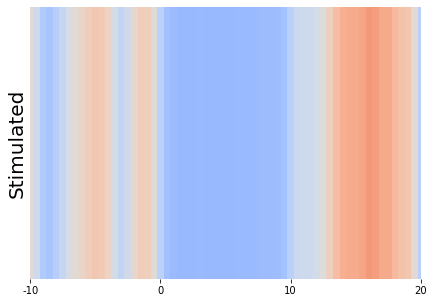

In [26]:
f, ax = plt.subplots(figsize=(7, 5))
ax.imshow(c2, cmap="coolwarm", vmin=-4.5, vmax=4.5, aspect="auto")


ax.set_ylabel("Stimulated", fontsize=20)
ax.set_yticklabels([])
ax.set_yticks([])

ax.set(frame_on=False)
ax.set_xlim(0, 60)
ax.set_xticks([0, 20, 40, 60])
ax.set_xticklabels([-10, 0, 10, 20])

# plt.savefig(fig_dir / "NSA_ramp_heat_activiated.svg", transparent=True, dpi=300)